# Projeto de Classificação de URLs Maliciosas

## Introdução

Este notebook implementa um sistema de classificação de URLs para identificar endereços maliciosos (phishing e malware) versus URLs benignas. O phishing e malware continuam sendo ameaças significativas no cenário de segurança cibernética, e a capacidade de detectar URLs maliciosas é crucial para proteger usuários e sistemas.

## Objetivos

1. Carregar e explorar o conjunto de dados de URLs maliciosas e benignas
2. Extrair características relevantes das URLs para identificação de padrões maliciosos
3. Treinar diferentes modelos de machine learning para classificação
4. Otimizar hiperparâmetros usando técnicas avançadas (Otimização Bayesiana)
5. Avaliar e comparar o desempenho dos modelos
6. Salvar os melhores modelos para uso futuro

## Dataset

Utilizamos o dataset "malicious-urls-dataset" disponível no Kaggle, que contém URLs classificadas como benignas, phishing ou malware. Este conjunto de dados fornece uma base sólida para treinar e testar nossos modelos de classificação.

# 1. Configuração do Ambiente e Preparação dos Dados

## 1.1 Configuração do Ambiente e Carregamento dos Dados

Primeiro, instalamos e importamos as bibliotecas necessárias. A biblioteca `kagglehub` nos permite baixar diretamente o conjunto de dados do Kaggle.

In [1]:
%pip install kagglehub


Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")
print(path)

/home/vscode/.cache/kagglehub/datasets/sid321axn/malicious-urls-dataset/versions/1


## 1.2 Bibliotecas e Configuração

Importamos diversas bibliotecas para processamento de dados, extração de características, modelagem e avaliação. Entre elas:

- **Processamento de dados**: pandas, urllib
- **Extração de características de URLs**: tldextract, tld (para obter informações sobre domínios e TLDs)
- **Machine Learning**: scikit-learn, XGBoost, LightGBM, CatBoost
- **Otimização de hiperparâmetros**: scikit-optimize (Bayesian Optimization)
- **Visualização**: matplotlib, seaborn

Desabilitamos avisos de usuário para manter a saída do notebook limpa.

In [3]:
import pandas as pd
from urllib.parse import urlparse
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier, Perceptron
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import re
import hashlib
import os
import joblib
from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

## 1.3 Carregamento e Exploração do Dataset

Carregamos o conjunto de dados e exploramos suas características iniciais. O dataset contém URLs classificadas em diferentes categorias (benignas, phishing e malware).

In [4]:
df = pd.read_csv(path + '/malicious_phish.csv')
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [5]:
print(df['type'].unique())

['phishing' 'benign' 'defacement' 'malware']


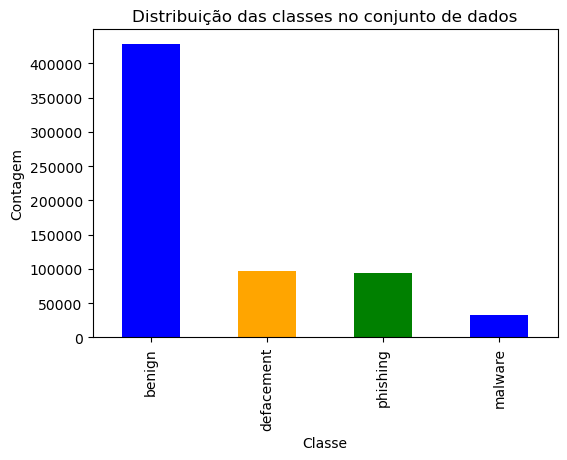

In [6]:
# Visualização da distribuição das classes
plt.figure(figsize=(6, 4))
df['type'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title("Distribuição das classes no conjunto de dados")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

## 1.4 Pré-processamento de Dados

Realizamos codificação das classes usando `LabelEncoder` para transformar as categorias textuais em valores numéricos que podem ser processados pelos algoritmos de machine learning.

In [7]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])
print(df['label'].unique())
df

[3 0 1 2]


,url,type,label
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


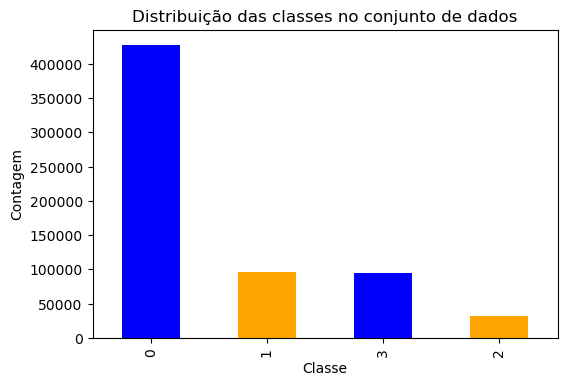

In [8]:
# Visualização da distribuição das classes codificadas
plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Distribuição das classes no conjunto de dados")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

# 2. Modelo Baseline Inicial

## 2.1 Vetorização Simples com N-gramas

Vamos criar uma representação inicial das URLs usando n-gramas de caracteres, que são sequências contíguas de n caracteres das URLs.

In [9]:
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(3, 3))
X = vectorizer.fit_transform(df['url']) # matriz de features
y = df['label'] # vector de etiquetas

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2.2 Modelo Inicial com XGBoost

Inicialmente, treinamos um modelo XGBoost usando a vetorização de n-gramas para criar uma linha de base para nosso problema de classificação. Esta abordagem nos permite avaliar o poder preditivo dos padrões de caracteres nas URLs.

In [11]:
clf = XGBClassifier(n_estimators=100, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [12]:
y_pred = clf.predict(X_test)

print("Relatório de Classificação: ")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Acurácia: ", accuracy_score(y_test, y_pred))

Relatório de Classificação: 
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85778
  defacement       0.97      0.99      0.98     19104
     malware       0.99      0.94      0.97      6521
    phishing       0.94      0.84      0.89     18836

    accuracy                           0.97    130239
   macro avg       0.97      0.94      0.95    130239
weighted avg       0.97      0.97      0.97    130239

Acurácia:  0.9670528797057717


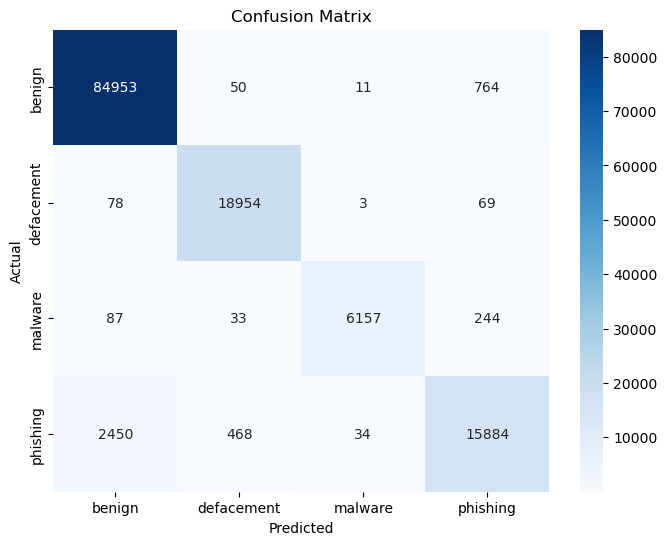

In [13]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3. Engenharia de Características

## 3.1 Características Básicas das URLs

Extraímos características estruturais básicas das URLs que podem ser indicativas de comportamento malicioso.

In [14]:
# Removendo os prefixos como https e www
def remove_prefix(url):
    for prefix in ['https://', 'http://', 'www.']:
        if url.startswith(prefix):
            url = url[len(prefix):]
    return url

df['url'] = df['url'].apply(remove_prefix)

In [15]:
# Comprimento da URL
def get_length(url):
    return len(url)

df['url_len'] = df['url'].apply(get_length)
df.head()

,url,type,label,url_len
0,br-icloud.com.br,phishing,3,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228


In [16]:
# Extração do domínio
def extract_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except:
        pri_domain = None
    return pri_domain

df['domain'] = df['url'].apply(extract_domain)

In [17]:
# Removendo URLs com domínios inválidos
df.dropna(subset=['domain'], inplace=True)
df

,url,type,label,url_len,domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net
...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,xbox360.ign.com
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,games.teamxbox.com
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38,gamespot.com
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,en.wikipedia.org


In [18]:
# Extração do domínio raiz
def extract_root_domain(url):
    extracted = tld_extract(url)
    root_domain = extracted.domain
    return root_domain

df['root_domain'] = df['url'].apply(extract_root_domain)
df.head()

,url,type,label,url_len,domain,root_domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua


In [19]:
# Verificação de valores nulos
df.isnull().sum()

url            0
type           0
label          0
url_len        0
domain         0
root_domain    0
dtype: int64

In [20]:
# Verificação de duplicatas
df.duplicated().sum()

11912

In [21]:
# Remoção de duplicatas
df.drop_duplicates(inplace=True)
df

,url,type,label,url_len,domain,root_domain
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua
...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3,39,xbox360.ign.com,ign
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3,44,games.teamxbox.com,teamxbox
651188,gamespot.com/xbox360/action/deadspace/,phishing,3,38,gamespot.com,gamespot
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3,45,en.wikipedia.org,wikipedia


In [22]:
# Contagem de caracteres especiais
special_chars = ['/', '?', '=', '-', '.', '@']

def count_special_chars(url):
    return sum(url.count(char) for char in special_chars)

df['special_char_count'] = df['url'].apply(count_special_chars)
df.head()

,url,type,label,url_len,domain,root_domain,special_char_count
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid,4
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets,5
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne,9
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua,8


In [23]:
# Contagem de subdomínios
def count_subdomains(url):
    # Divide the URL by '.' to count the segments.
    parts = url.split('.')
    # Consider that a valid domain has at least a domain and TLD.
    return max(0, len(parts) - 2)

df['subdomain_count'] = df['url'].apply(count_subdomains)
df[['url', 'subdomain_count']].head()

,url,subdomain_count
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,1
2,bopsecrets.org/rexroth/cr/1.htm,1
3,garage-pirenne.be/index.php?option=com_content...,1
4,adventure-nicaragua.net/index.php?option=com_m...,1


In [24]:
# Proporção de dígitos vs. letras
def digit_letter_ratio(url):
    digit_count = sum(c.isdigit() for c in url)
    letter_count = sum(c.isalpha() for c in url)
    return digit_count / letter_count if letter_count > 0 else digit_count

df['digit_letter_ratio'] = df['url'].apply(digit_letter_ratio)
df.head()

,url,type,label,url_len,domain,root_domain,special_char_count,subdomain_count,digit_letter_ratio
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,br-icloud,3,1,0.000000
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,mp3raid,4,1,0.034483
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,bopsecrets,5,1,0.040000
3,garage-pirenne.be/index.php?option=com_content...,defacement,1,77,garage-pirenne.be,garage-pirenne,9,1,0.125000
4,adventure-nicaragua.net/index.php?option=com_m...,defacement,1,228,adventure-nicaragua.net,adventure-nicaragua,8,1,0.112821


In [25]:
# Extração de TLD (Top-Level Domain)
def extract_tld(url):
    extracted = tld_extract(url)
    return extracted.suffix

df['tld'] = df['url'].apply(extract_tld)
print(df['tld'].value_counts())

tld
com           392775
org            50733
net            28025
de             13443
edu            10077
               ...  
czest.pl           1
donetsk.ua         1
edu.bb             1
edu.om             1
net.hk             1
Name: count, Length: 883, dtype: int64


In [26]:
# Criando conjunto de dados para modelagem
data = df.drop(columns=['url', 'type', 'domain'])
data.head()

,label,url_len,root_domain,special_char_count,subdomain_count,digit_letter_ratio,tld
0,3,16,br-icloud,3,1,0.000000,com.br
1,0,35,mp3raid,4,1,0.034483,com
2,0,31,bopsecrets,5,1,0.040000,org
3,1,77,garage-pirenne,9,1,0.125000,be
4,1,228,adventure-nicaragua,8,1,0.112821,net


In [27]:
# Aplicando target encoding para o domínio raiz
target_mapping = data.groupby('root_domain')['label'].mean().to_dict()
data['root_domain'] = data['root_domain'].map(target_mapping)
len(data['root_domain'].unique())

559

In [28]:
# Aplicando target encoding para o TLD
target_mapping_tld = data.groupby('tld')['label'].mean().to_dict()
data['tld'] = data['tld'].map(target_mapping_tld)
len(data['tld'].unique())

278

In [29]:
# Divisão em conjuntos de treino e teste
x = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## 3.2 Engenharia de Características Avançadas

Para melhorar ainda mais a capacidade de detecção do nosso modelo, implementamos técnicas mais sofisticadas de engenharia de características:

### 3.2.1 Análise de Entropia da URL

A entropia é uma medida da aleatoriedade em uma sequência de caracteres. URLs maliciosas frequentemente contêm partes geradas aleatoriamente ou codificadas para evitar detecção. Uma alta entropia pode indicar um comportamento suspeito.

Usaremos a teoria da informação de Shannon para calcular a entropia:

$$H(X) = -\sum_{i=1}^{n} P(x_i) \log_2 P(x_i)$$

Onde $P(x_i)$ é a probabilidade do caractere $x_i$ na URL.

Estatísticas de entropia para URLs benignas:
count    427161.000000
mean          4.203520
std           0.396298
min           1.610785
25%           3.957853
50%           4.216055
75%           4.459839
max           7.237810
Name: url_entropy, dtype: float64

Estatísticas de entropia para URLs maliciosas:
count    199901.000000
mean          4.176451
std           0.457429
min           1.867634
25%           3.886842
50%           4.175123
75%           4.504248
max           7.504113
Name: url_entropy, dtype: float64


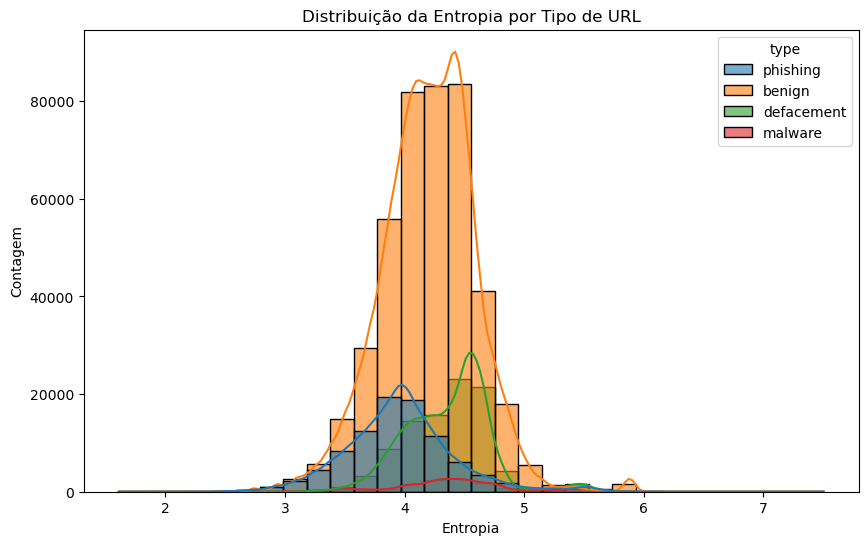

In [30]:
def shannon_entropy(url):
    """Calcula a entropia de Shannon para uma URL.

    A entropia é uma medida da aleatoriedade dos caracteres. URLs maliciosas
    frequentemente contêm partes geradas aleatoriamente para evitar detecção.
    """
    if not url:
        return 0

    # Contagem da frequência de cada caractere
    char_count = {}
    for char in url:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1

    # Cálculo da entropia
    entropy = 0
    length = len(url)
    for count in char_count.values():
        probability = count / length
        entropy -= probability * math.log2(probability)

    return entropy

# Calculando a entropia para cada URL
df['url_entropy'] = df['url'].apply(shannon_entropy)

# Exibindo as estatísticas da entropia
print("Estatísticas de entropia para URLs benignas:")
print(df[df['type'] == 'benign']['url_entropy'].describe())

print("\nEstatísticas de entropia para URLs maliciosas:")
print(df[df['type'] != 'benign']['url_entropy'].describe())

# Histograma comparativo da distribuição da entropia
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='url_entropy', hue='type', bins=30, kde=True, alpha=0.6)
plt.title('Distribuição da Entropia por Tipo de URL')
plt.xlabel('Entropia')
plt.ylabel('Contagem')
plt.show()

### 3.2.2 Detecção de Técnicas de Ofuscação

Atacantes frequentemente usam técnicas de ofuscação para enganar usuários, fazendo com que URLs maliciosas pareçam legítimas. Implementaremos dois tipos de detecção:

1. **Detecção de Homógrafos**: Identifica caracteres que parecem visualmente semelhantes a outros (como usar '1' no lugar de 'l', 'O' no lugar de '0')
2. **Detecção de Typosquatting**: Identifica domínios que são variações com erros de digitação comuns de domínios populares (como 'g00gle.com' em vez de 'google.com')

URLs com homógrafos: 627062 (100.00%)
Média de caracteres confundíveis por URL: 27.34
Score médio de typosquatting: 0.3428

Comparação de técnicas de ofuscação:
Homógrafos em URLs benignas: 100.00%
Homógrafos em URLs maliciosas: 100.00%
Caracteres confundíveis em URLs benignas: 27.14
Caracteres confundíveis em URLs maliciosas: 27.75
Score de typosquatting em URLs benignas: 0.3627
Score de typosquatting em URLs maliciosas: 0.3003


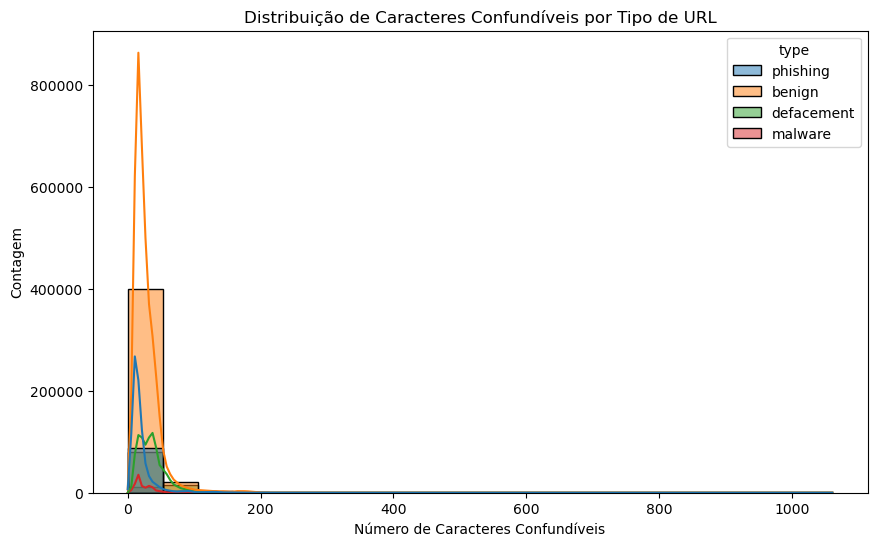

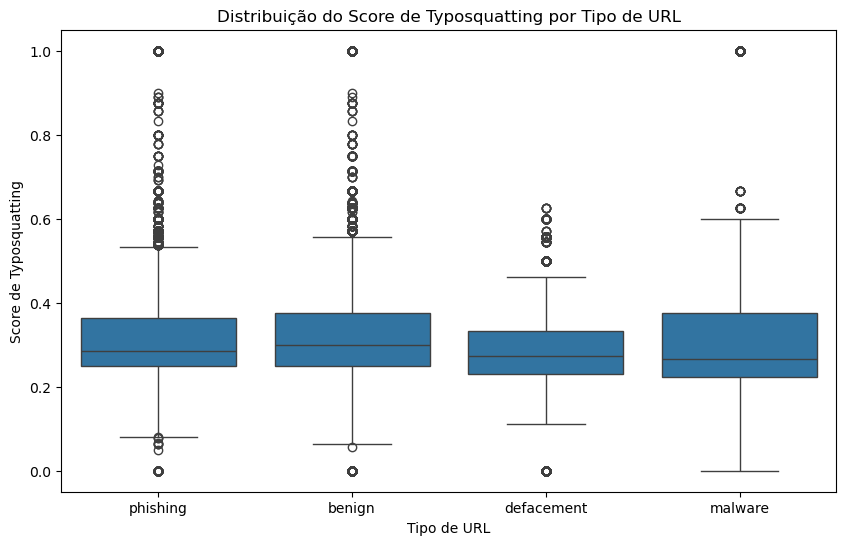

In [31]:
from confusable_homoglyphs import confusables
import distance

# Lista de domínios populares para verificação de typosquatting
popular_domains = [
    'google', 'facebook', 'youtube', 'twitter', 'instagram',
    'linkedin', 'amazon', 'microsoft', 'apple', 'netflix',
    'paypal', 'whatsapp', 'gmail', 'yahoo', 'hotmail',
    'outlook', 'dropbox', 'reddit', 'ebay', 'pinterest'
]

# Mapeamento de caracteres confundíveis
confusable_chars = {
    '0': 'o', 'O': '0', 'l': '1', '1': 'l', 'I': 'l',
    'i': 'l', 'S': '5', '5': 's', 'a': '@', '@': 'a',
    'e': '3', '3': 'e', 'g': '9', '9': 'g', 'b': '6',
    '6': 'b', 't': '7', '7': 't', 'w': 'vv', 'vv': 'w',
    'm': 'nn', 'nn': 'm', 'c': '(', '(': 'c'
}

def has_homographs(text):
    """Verifica se o texto contém caracteres homógrafos."""
    for char in text:
        if confusables.is_confusable(char, ['latin']):  # verifica se o caractere é confundível
            return True
    return False

def count_confusable_chars(text):
    """Conta o número de caracteres confundíveis no texto."""
    count = 0
    for char in text:
        if char.lower() in confusable_chars or char in confusable_chars:
            count += 1
    return count

def typosquatting_score(domain):
    """Calcula um score de typosquatting baseado na distância de Levenshtein.

    Retorna a menor distância para qualquer domínio popular (normalizada).
    Um valor baixo indica possível typosquatting.
    """
    if not domain:
        return 0

    # Remova subdomínios, se houver
    if '.' in domain:
        domain = domain.split('.')[0]

    min_distance = float('inf')
    for pop_domain in popular_domains:
        # Distância de Levenshtein normalizada
        dist = distance.levenshtein(domain.lower(), pop_domain) / max(len(domain), len(pop_domain))
        min_distance = min(min_distance, dist)

    # Inverte o score para que valores mais altos indiquem maior probabilidade de typosquatting
    return 1 - min_distance if min_distance <= 1 else 0

# Aplicando as funções de detecção no dataset
df['has_homographs'] = df['url'].apply(has_homographs)
df['confusable_chars_count'] = df['url'].apply(count_confusable_chars)
df['typosquatting_score'] = df['root_domain'].apply(typosquatting_score)

# Exibindo resultados
print(f"URLs com homógrafos: {df['has_homographs'].sum()} ({df['has_homographs'].mean()*100:.2f}%)")
print(f"Média de caracteres confundíveis por URL: {df['confusable_chars_count'].mean():.2f}")
print(f"Score médio de typosquatting: {df['typosquatting_score'].mean():.4f}")

# Comparação entre URLs benignas e maliciosas
benign_mask = df['type'] == 'benign'
malicious_mask = ~benign_mask

print("\nComparação de técnicas de ofuscação:")
print(f"Homógrafos em URLs benignas: {df[benign_mask]['has_homographs'].mean()*100:.2f}%")
print(f"Homógrafos em URLs maliciosas: {df[malicious_mask]['has_homographs'].mean()*100:.2f}%")
print(f"Caracteres confundíveis em URLs benignas: {df[benign_mask]['confusable_chars_count'].mean():.2f}")
print(f"Caracteres confundíveis em URLs maliciosas: {df[malicious_mask]['confusable_chars_count'].mean():.2f}")
print(f"Score de typosquatting em URLs benignas: {df[benign_mask]['typosquatting_score'].mean():.4f}")
print(f"Score de typosquatting em URLs maliciosas: {df[malicious_mask]['typosquatting_score'].mean():.4f}")

# Visualizando a distribuição de caracteres confundíveis
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='confusable_chars_count', hue='type', kde=True, bins=20)
plt.title('Distribuição de Caracteres Confundíveis por Tipo de URL')
plt.xlabel('Número de Caracteres Confundíveis')
plt.ylabel('Contagem')
plt.show()

# Visualizando scores de typosquatting
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type', y='typosquatting_score')
plt.title('Distribuição do Score de Typosquatting por Tipo de URL')
plt.xlabel('Tipo de URL')
plt.ylabel('Score de Typosquatting')
plt.show()

### 3.2.2.1 Aprimoramentos na Detecção de Técnicas de Ofuscação

Vamos implementar técnicas avançadas para melhorar a detecção de ofuscação em URLs:

1. **Expansão da detecção de homógrafos**: Adicionando análise específica para domínios sensíveis
2. **Refinamento do score de typosquatting**: Utilizando múltiplas métricas de distância com pesos diferenciados
3. **Análise contextual**: Verificando TLDs confundíveis e substituições estratégicas
4. **Normalização e combinação de features**: Criando um score combinado de ofuscação

In [32]:
import jellyfish


Estatísticas das novas características:
Score médio de homógrafos: 1.0000
Score médio de typosquatting refinado: 0.3987
Score médio contextual: 0.4483
Score médio de ofuscação: 0.6117

Comparação de técnicas avançadas de ofuscação:
Score de homógrafos em URLs benignas: 1.0000
Score de homógrafos em URLs maliciosas: 1.0000
Score de typosquatting refinado em URLs benignas: 0.4169
Score de typosquatting refinado em URLs maliciosas: 0.3597
Score contextual em URLs benignas: 0.4882
Score contextual em URLs maliciosas: 0.3631
Score de ofuscação em URLs benignas: 0.6242
Score de ofuscação em URLs maliciosas: 0.5851


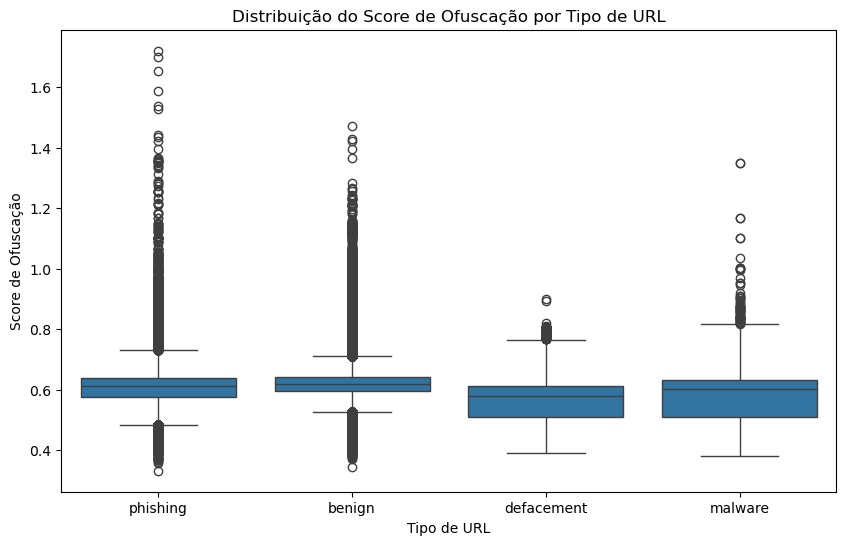

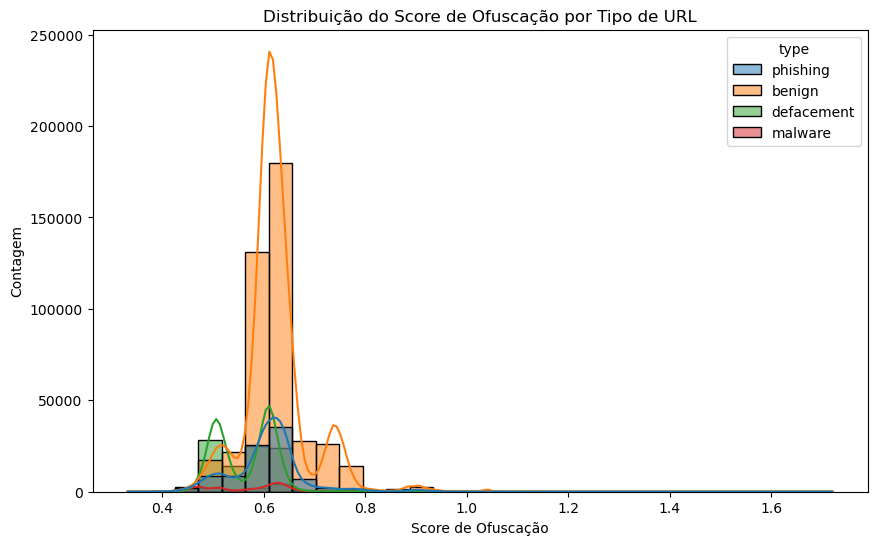

In [33]:
# 1. Expansão da detecção de homógrafos
def enhanced_homograph_detection(text):
    """
    Detecção avançada de homógrafos com análise específica para domínios sensíveis.
    Retorna um score de risco baseado no tipo de homógrafo detectado.
    """
    # Verificação básica
    basic_check = confusables.is_confusable(text, ['latin'])

    # Domínios sensíveis que requerem maior atenção
    sensitive_domains = ['paypal', 'bank', 'login', 'account', 'secure', 'apple',
                        'microsoft', 'google', 'facebook', 'amazon', 'netflix',
                        'instagram', 'whatsapp', 'outlook', 'gmail']

    # Verificar padrões específicos de homógrafos em domínios sensíveis
    for domain in sensitive_domains:
        if domain in text.lower() and confusables.is_dangerous(text, domain):
            return 2  # Pontuação maior para homógrafos em domínios sensíveis

    return 1 if basic_check else 0

# 2. Refinamento do score de typosquatting
def improved_typosquatting_score(domain):
    """
    Calcula um score de typosquatting mais refinado usando múltiplas métricas
    de distância com pesos diferenciados.
    """
    if not domain:
        return 0

    scores = []
    for pop_domain in popular_domains:
        # Distância de Levenshtein
        lev_dist = distance.levenshtein(domain.lower(), pop_domain)

        # Usamos levenshtein novamente como aproximação para Damerau-Levenshtein
        dam_dist = distance.levenshtein(domain.lower(), pop_domain)

        # Distância de Jaro-Winkler (dá mais peso ao início da string)
        jaro_dist = jellyfish.jaro_winkler_similarity(domain.lower(), pop_domain)

        # Combinar scores com pesos diferenciados
        combined_score = (0.5 * (1 - lev_dist/max(len(domain), len(pop_domain)))) + \
                        (0.3 * (1 - dam_dist/max(len(domain), len(pop_domain)))) + \
                        (0.2 * jaro_dist)

        scores.append(combined_score)

    return max(scores)

# 3. Análise contextual
def contextual_analysis(url, domain):
    """
    Realiza análise contextual da URL verificando TLDs confundíveis
    e substituições estratégicas de caracteres.
    """
    score = 0

    # Verificar se há mistura de TLDs confundíveis
    common_tlds = ['.com', '.org', '.net', '.edu']
    confusable_tlds = ['.co', '.cm', '.om', '.rn', '.ne', '.or', '.ed']

    for c_tld in confusable_tlds:
        if c_tld in url:
            for tld in common_tlds:
                # Verifica se a URL contém tanto o TLD confundível quanto parte do TLD legítimo
                if tld.replace(c_tld, '') in url:
                    score += 0.5

    # Verificar se há números substituindo letras em posições estratégicas
    if domain:
        for i, char in enumerate(domain):
            if char.isdigit() and i > 0 and i < len(domain)-1:
                if char in confusable_chars and confusable_chars[char].isalpha():
                    score += 0.3

    return score

# Aplicando as novas funções ao dataset
df['homograph_score'] = df['url'].apply(enhanced_homograph_detection)
df['refined_typosquatting'] = df['root_domain'].apply(improved_typosquatting_score)
df['context_score'] = df.apply(lambda x: contextual_analysis(x['url'], x['root_domain']), axis=1)

# 4. Normalização e combinação de features para criar um "score de ofuscação"
# Convertendo confusable_chars_count para uma taxa baseada no comprimento da URL
df['confusable_ratio'] = df['confusable_chars_count'] / df['url_len']

# Score combinado de ofuscação
df['obfuscation_score'] = (
    0.3 * df['homograph_score'] +
    0.3 * df['confusable_ratio'] +
    0.2 * df['refined_typosquatting'] +
    0.2 * df['context_score']
)

# Exibindo estatísticas sobre as novas características
print("\nEstatísticas das novas características:")
print(f"Score médio de homógrafos: {df['homograph_score'].mean():.4f}")
print(f"Score médio de typosquatting refinado: {df['refined_typosquatting'].mean():.4f}")
print(f"Score médio contextual: {df['context_score'].mean():.4f}")
print(f"Score médio de ofuscação: {df['obfuscation_score'].mean():.4f}")

# Comparação entre URLs benignas e maliciosas com as novas métricas
print("\nComparação de técnicas avançadas de ofuscação:")
print(f"Score de homógrafos em URLs benignas: {df[benign_mask]['homograph_score'].mean():.4f}")
print(f"Score de homógrafos em URLs maliciosas: {df[malicious_mask]['homograph_score'].mean():.4f}")
print(f"Score de typosquatting refinado em URLs benignas: {df[benign_mask]['refined_typosquatting'].mean():.4f}")
print(f"Score de typosquatting refinado em URLs maliciosas: {df[malicious_mask]['refined_typosquatting'].mean():.4f}")
print(f"Score contextual em URLs benignas: {df[benign_mask]['context_score'].mean():.4f}")
print(f"Score contextual em URLs maliciosas: {df[malicious_mask]['context_score'].mean():.4f}")
print(f"Score de ofuscação em URLs benignas: {df[benign_mask]['obfuscation_score'].mean():.4f}")
print(f"Score de ofuscação em URLs maliciosas: {df[malicious_mask]['obfuscation_score'].mean():.4f}")

# Visualização do score de ofuscação combinado
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type', y='obfuscation_score')
plt.title('Distribuição do Score de Ofuscação por Tipo de URL')
plt.xlabel('Tipo de URL')
plt.ylabel('Score de Ofuscação')
plt.show()

# Histograma do score de ofuscação
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='obfuscation_score', hue='type', kde=True, bins=30)
plt.title('Distribuição do Score de Ofuscação por Tipo de URL')
plt.xlabel('Score de Ofuscação')
plt.ylabel('Contagem')
plt.show()

### 3.2.3 Extração Avançada de N-gramas

As técnicas tradicionais de extração de n-gramas têm algumas limitações. Vamos implementar uma abordagem mais sofisticada que combina:

1. **N-gramas com pesos**: Diferentes comprimentos de n-gramas podem ter importâncias diferentes
2. **N-gramas posicionais**: A posição do n-grama na URL pode ser relevante (início, meio ou fim)
3. **TF-IDF adaptado**: Aplicação de TF-IDF com normalização específica para URLs
4. **Seleção automática de características**: Uso de técnicas como Chi-squared para selecionar os n-gramas mais relevantes

Dimensão original de características TF-IDF: 5000
Dimensão após seleção: 2000

Características mais importantes (TF-IDF):
1. .exe (score: 38145.5201)
2. exe  (score: 37999.0096)
3. xe  (score: 37719.3876)
4. .ex (score: 36372.2504)
5. exe (score: 31650.3595)
6. xe (score: 21460.5253)
7. &i (score: 17330.6494)
8. i-jy (score: 16669.6056)
9. -jyu (score: 16663.4811)
10. jyuk (score: 16660.4280)
11. ku.m (score: 16642.4819)
12. h.jp (score: 16632.7728)
13. ixh. (score: 16632.2217)
14. u.mi (score: 16630.7314)
15. ui-j (score: 16630.6131)
16. sui- (score: 16624.4003)
17. jp/u (score: 16621.6813)
18. xh.j (score: 16619.6219)
19. mixh (score: 16619.6219)
20. .mix (score: 16564.4818)


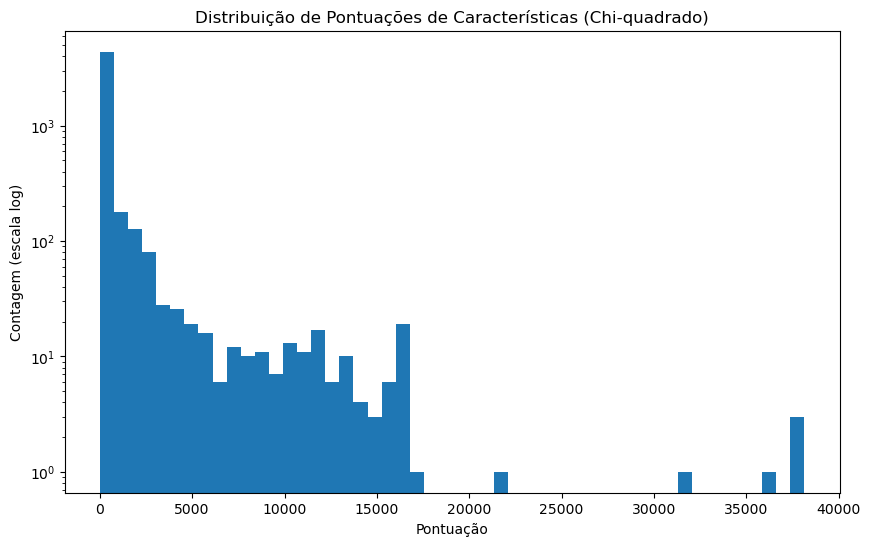

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from nltk import ngrams

# Função para segmentar a URL em partes específicas
def segment_url(url):
    """Divide a URL em segmentos significativos: protocolo, domínio, caminho, parâmetros, etc."""
    parts = {}

    # Extrair protocolo, se presente
    protocol_match = re.match(r'^(https?://)?(.*)', url, re.IGNORECASE)
    if protocol_match:
        parts['protocol'] = protocol_match.group(1) or ''
        remaining = protocol_match.group(2)
    else:
        parts['protocol'] = ''
        remaining = url

    # Separar domínio do caminho
    if '/' in remaining:
        domain, path = remaining.split('/', 1)
        parts['domain'] = domain
        parts['path'] = '/' + path
    else:
        parts['domain'] = remaining
        parts['path'] = ''

    # Separar parâmetros da consulta e fragmento
    if '?' in parts['path']:
        path_part, query = parts['path'].split('?', 1)
        parts['path'] = path_part

        if '#' in query:
            query_part, fragment = query.split('#', 1)
            parts['query'] = query_part
            parts['fragment'] = '#' + fragment
        else:
            parts['query'] = query
            parts['fragment'] = ''
    elif '#' in parts['path']:
        path_part, fragment = parts['path'].split('#', 1)
        parts['path'] = path_part
        parts['query'] = ''
        parts['fragment'] = '#' + fragment
    else:
        parts['query'] = ''
        parts['fragment'] = ''

    return parts

# Extração de n-gramas posicionais
def extract_positional_ngrams(url, n=3):
    """Extrai n-gramas com informação posicional para diferenciar o início, meio e fim da URL."""
    segments = segment_url(url)
    result = []

    # Adiciona prefixos posicionais aos n-gramas
    for segment_type, segment in segments.items():
        if (segment):
            # Cria n-gramas para esta parte específica da URL
            segment_ngrams = ['{}_{}'.format(segment_type, ''.join(ng))
                             for ng in ngrams(segment, n)]
            result.extend(segment_ngrams)

    return result

# Preparação para vetorização TF-IDF com n-gramas posicionais
df['positional_ngrams'] = df['url'].apply(lambda x: ' '.join(extract_positional_ngrams(x, 3)))

# Vetorização TF-IDF com n-gramas de caracteres variáveis (2-4 caracteres)
tfidf_vectorizer = TfidfVectorizer(
    analyzer='char_wb',  # análise de caracteres com limites de palavras
    ngram_range=(2, 4),  # combinação de n-gramas de 2 a 4 caracteres
    max_features=5000,   # limita o número de características
    sublinear_tf=True,   # aplica escala logarítmica ao termo frequência
    use_idf=True,        # usa inverso da frequência do documento
    norm='l2'            # normalização L2
)

# Vetorização para n-gramas posicionais
positional_vectorizer = TfidfVectorizer(
    analyzer='word',      # análise de palavras (cada n-grama posicional é uma "palavra")
    max_features=3000,    # limita o número de características
    use_idf=True,         # usa inverso da frequência do documento
    sublinear_tf=True     # aplica escala logarítmica ao termo frequência
)

# Aplicação da vetorização
X_tfidf = tfidf_vectorizer.fit_transform(df['url'])
X_positional = positional_vectorizer.fit_transform(df['positional_ngrams'])

# Seleção de características baseada em chi-quadrado
# Seleciona as k melhores características com base no teste estatístico chi-quadrado
selector = SelectKBest(chi2, k=min(2000, X_tfidf.shape[1]))
X_tfidf_selected = selector.fit_transform(X_tfidf, df['label'])

# Exibindo informações sobre as características selecionadas
print(f"Dimensão original de características TF-IDF: {X_tfidf.shape[1]}")
print(f"Dimensão após seleção: {X_tfidf_selected.shape[1]}")

# Verificando as características mais importantes
if hasattr(selector, 'scores_'):
    # Obtendo índices das características ordenadas por importância
    indices = np.argsort(selector.scores_)[::-1][:20]  # Top 20 características
    feature_names = tfidf_vectorizer.get_feature_names_out()

    print("\nCaracterísticas mais importantes (TF-IDF):")
    for i, idx in enumerate(indices):
        if (idx < len(feature_names)):
            print(f"{i+1}. {feature_names[idx]} (score: {selector.scores_[idx]:.4f})")

# Visualizando a distribuição das pontuações de características
plt.figure(figsize=(10, 6))
plt.hist(selector.scores_, bins=50, log=True)
plt.title('Distribuição de Pontuações de Características (Chi-quadrado)')
plt.xlabel('Pontuação')
plt.ylabel('Contagem (escala log)')
plt.show()

## 3.3 Integração de Características Avançadas

Combinamos todas as características extraídas para criar um conjunto de dados enriquecido para modelagem.

In [35]:
# Adicionando as novas características avançadas ao conjunto de dados original
advanced_features = df[['url_entropy', 'has_homographs', 'confusable_chars_count', 'typosquatting_score']].copy()

# Converter colunas booleanas para numéricas
advanced_features['has_homographs'] = advanced_features['has_homographs'].astype(int)

# Adicionando essas características ao conjunto de dados
data_advanced = data.copy()
data_advanced = pd.concat([data_advanced, advanced_features], axis=1)

# Verificando as novas colunas adicionadas
print("Novas características adicionadas:")
for col in advanced_features.columns:
    print(f"- {col}")

# Preparando os dados para o modelo
X_advanced = data_advanced.drop(columns=['label'])
y_advanced = data_advanced['label']

# Dividindo em conjuntos de treino e teste
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced, y_advanced, test_size=0.3, random_state=42
)

Novas características adicionadas:
- url_entropy
- has_homographs
- confusable_chars_count
- typosquatting_score


# 4. Modelagem e Avaliação

## 4.1 Otimização Bayesiana de Hiperparâmetros

Para encontrar os melhores hiperparâmetros para nossos modelos, utilizamos a Otimização Bayesiana através da biblioteca `scikit-optimize`. Esta técnica é mais eficiente que a busca em grade tradicional, pois:

1. Aprende com os resultados anteriores para escolher os próximos pontos a serem avaliados
2. Pode encontrar melhores parâmetros com menos iterações
3. Trabalha bem com espaços de busca contínuos

Definimos espaços de busca específicos para cada tipo de classificador, considerando diferentes estratégias para cada algoritmo.

In [36]:
# Configuração para otimização bayesiana
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Espaços de busca para cada classificador
param_spaces = {
    'RandomForestClassifier': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    'XGBClassifier': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'learning_rate': (0.01, 0.3, 'log-uniform')
    },
    'AdaBoostClassifier': {
        'n_estimators': (50, 200),
        'learning_rate': (0.01, 1.0, 'log-uniform')
    },
    'KNeighborsClassifier': {
        'n_neighbors': (1, 30),
        'weights': ['uniform', 'distance'],
        'p': (1, 2)  # 1 para Manhattan, 2 para Euclidiana
    },
    'DecisionTreeClassifier': {
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    'ExtraTreesClassifier': {
        'n_estimators': (50, 500),
        'max_depth': (3, 20),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },
    'GaussianNB': {
        'var_smoothing': (1e-9, 1e-5, 'log-uniform')
    }
}

# Lista de classificadores
classificadores = [
    RandomForestClassifier(random_state=42),
    XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42),
    AdaBoostClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42)
    #GaussianNB()
]

In [37]:
# Otimização de hiperparâmetros e avaliação de modelos
results = []
modelos = {}

for clf in classificadores:
    if clf.__class__.__name__ not in param_spaces:
        print(f"Espaço de busca não definido para {clf.__class__.__name__}. Pulando...")
        continue

    print(f"Treinando {clf.__class__.__name__}...")

    bayes_search = BayesSearchCV(
        estimator = clf,
        search_spaces = param_spaces[clf.__class__.__name__],
        n_iter=32,
        cv=cv,
        scoring='accuracy',
        random_state=42,
        n_jobs=2
    )

    bayes_search.fit(x, y)

    print(f"Melhores parâmetros para {clf.__class__.__name__}:", bayes_search.best_params_)
    print(f"Melhor acurácia de validação para {clf.__class__.__name__}:", bayes_search.best_score_)
    print("-" * 50)

    best_clf = bayes_search.best_estimator_

    pipeline = Pipeline([
        ('classifier', best_clf)
    ])
    scores = cross_val_score(pipeline, data.drop(columns=['label']), data['label'], cv=5, scoring='accuracy')
    y_pred = cross_val_predict(pipeline, x, y, cv=5)
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='weighted')
    precision = precision_score(y, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y, y_pred, average='weighted')
    modelos[clf.__class__.__name__] = best_clf
    results.append((clf.__class__.__name__, accuracy, recall, precision, f1))


Treinando RandomForestClassifier...


/opt/conda/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores parâmetros para RandomForestClassifier: OrderedDict({'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500})
Melhor acurácia de validação para RandomForestClassifier: 0.9747122288172297
--------------------------------------------------
Treinando XGBClassifier...


/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:29:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:29:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:29:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:29:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [05:30:11] WARNING: /w

Melhores parâmetros para XGBClassifier: OrderedDict({'learning_rate': 0.023280016501525152, 'max_depth': 11, 'n_estimators': 380})
Melhor acurácia de validação para XGBClassifier: 0.9751045354174558
--------------------------------------------------
Treinando AdaBoostClassifier...


/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Melhores parâmetros para AdaBoostClassifier: OrderedDict({'learning_rate': 0.3875621944495683, 'n_estimators': 50})
Melhor acurácia de validação para AdaBoostClassifier: 0.9566087574889099
--------------------------------------------------


/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/conda/lib/python3.1

Treinando KNeighborsClassifier...
Melhores parâmetros para KNeighborsClassifier: OrderedDict({'n_neighbors': 8, 'p': 1, 'weights': 'distance'})
Melhor acurácia de validação para KNeighborsClassifier: 0.961648129614996
--------------------------------------------------
Treinando DecisionTreeClassifier...
Melhores parâmetros para DecisionTreeClassifier: OrderedDict({'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 9})
Melhor acurácia de validação para DecisionTreeClassifier: 0.9736294021897359
--------------------------------------------------
Treinando ExtraTreesClassifier...
Melhores parâmetros para ExtraTreesClassifier: OrderedDict({'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50})
Melhor acurácia de validação para ExtraTreesClassifier: 0.9731509811323127
--------------------------------------------------


In [38]:
# Visualização dos resultados dos modelos
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1 Score'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)
results_df

,Classifier,Accuracy,Recall,Precision,F1 Score
0,RandomForestClassifier,0.959951,0.959951,0.959983,0.959959
1,XGBClassifier,0.959278,0.959278,0.959246,0.959253
5,ExtraTreesClassifier,0.958934,0.958934,0.958671,0.958777
4,DecisionTreeClassifier,0.958631,0.958631,0.958366,0.958483
2,AdaBoostClassifier,0.948267,0.948267,0.945379,0.944275
3,KNeighborsClassifier,0.944423,0.944423,0.944964,0.944477


## 4.2 Avaliação do Modelo com Características Avançadas

In [39]:
# Treinando um modelo com as características avançadas
# Usaremos XGBoost por seu bom desempenho nos testes anteriores
model_advanced = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Treinando o modelo com características avançadas
model_advanced.fit(X_train_adv, y_train_adv)

# Predições e avaliação
y_pred_adv = model_advanced.predict(X_test_adv)

# Métricas de avaliação
accuracy_adv = accuracy_score(y_test_adv, y_pred_adv)
recall_adv = recall_score(y_test_adv, y_pred_adv, average='weighted')
precision_adv = precision_score(y_test_adv, y_pred_adv, average='weighted', zero_division=1)
f1_adv = f1_score(y_test_adv, y_pred_adv, average='weighted')

print("\nResultados do modelo com características avançadas:")
print(f"Acurácia: {accuracy_adv:.4f}")
print(f"Recall: {recall_adv:.4f}")
print(f"Precisão: {precision_adv:.4f}")
print(f"F1-Score: {f1_adv:.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test_adv, y_pred_adv, target_names=label_encoder.classes_))


Resultados do modelo com características avançadas:
Acurácia: 0.9744
Recall: 0.9744
Precisão: 0.9741
F1-Score: 0.9742

Relatório de Classificação:
              precision    recall  f1-score   support

      benign       0.98      0.99      0.98    128015
  defacement       0.99      1.00      0.99     28752
     malware       0.96      0.98      0.97      3529
    phishing       0.94      0.90      0.92     27823

    accuracy                           0.97    188119
   macro avg       0.97      0.97      0.97    188119
weighted avg       0.97      0.97      0.97    188119



## 4.3 Comparação de Modelos

Comparamos o desempenho dos modelos com e sem as características avançadas para quantificar o impacto dessas novas features na detecção de URLs maliciosas.

In [40]:
# Comparando o desempenho dos modelos com e sem características avançadas
# Treinando um modelo equivalente com o conjunto básico de características
model_basic = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Treinando o modelo com características básicas
model_basic.fit(X_train, y_train)
y_pred_basic = model_basic.predict(X_test)

# Métricas de avaliação do modelo básico
accuracy_basic = accuracy_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic, average='weighted')
precision_basic = precision_score(y_test, y_pred_basic, average='weighted', zero_division=1)
f1_basic = f1_score(y_test, y_pred_basic, average='weighted')

# Criando um dataframe para comparação
comparison_df = pd.DataFrame({
    'Modelo': ['Básico', 'Avançado'],
    'Acurácia': [accuracy_basic, accuracy_adv],
    'Recall': [recall_basic, recall_adv],
    'Precisão': [precision_basic, precision_adv],
    'F1-Score': [f1_basic, f1_adv]
})

# Exibindo a comparação
print("Comparação de desempenho entre modelos:")
print(comparison_df)

# Calculando as melhorias percentuais
improvement_acc = ((accuracy_adv - accuracy_basic) / accuracy_basic) * 100
improvement_recall = ((recall_adv - recall_basic) / recall_basic) * 100
improvement_precision = ((precision_adv - precision_basic) / precision_basic) * 100
improvement_f1 = ((f1_adv - f1_basic) / f1_basic) * 100

print(f"\nMelhoria percentual com características avançadas:")
print(f"Acurácia: {improvement_acc:.2f}%")
print(f"Recall: {improvement_recall:.2f}%")
print(f"Precisão: {improvement_precision:.2f}%")
print(f"F1-Score: {improvement_f1:.2f}%")

Comparação de desempenho entre modelos:
     Modelo  Acurácia    Recall  Precisão  F1-Score
0    Básico  0.974862  0.974862  0.974602  0.974653
1  Avançado  0.974378  0.974378  0.974110  0.974171

Melhoria percentual com características avançadas:
Acurácia: -0.05%
Recall: -0.05%
Precisão: -0.05%
F1-Score: -0.05%


## 4.4 Visualização de Resultados

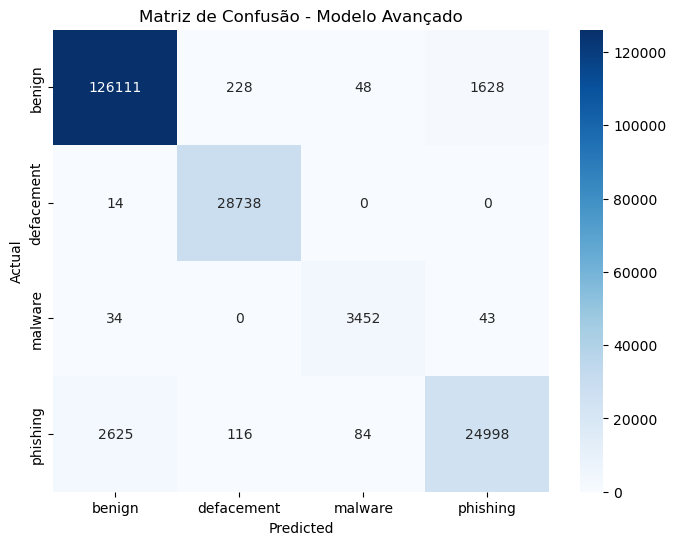

In [41]:
# Matriz de Confusão para o modelo avançado
cm_adv = confusion_matrix(y_test_adv, y_pred_adv)

plt.figure(figsize=(8,6))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusão - Modelo Avançado')
plt.show()

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:52:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:52:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:52:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:52:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [07:52:49] WARNING: /w

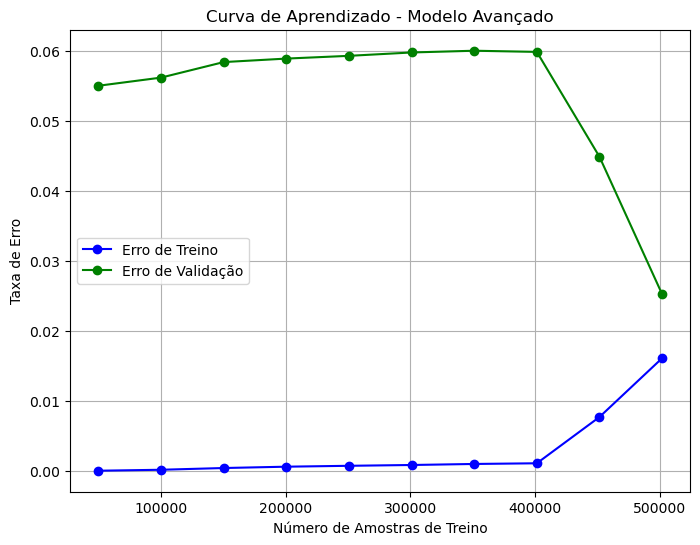

In [42]:
# Curvas de aprendizado
from sklearn.model_selection import learning_curve

# Obter os tamanhos de treino e as pontuações para treino e validação
train_sizes, train_scores, valid_scores = learning_curve(
    model_advanced, X_advanced, y_advanced, cv=cv, scoring='accuracy', n_jobs=2, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcular os erros (taxa de erro = 1 - acurácia)
train_errors = 1 - np.mean(train_scores, axis=1)
valid_errors = 1 - np.mean(valid_scores, axis=1)

# Plotar as curvas de aprendizado
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, 'o-', color='blue', label='Erro de Treino')
plt.plot(train_sizes, valid_errors, 'o-', color='green', label='Erro de Validação')
plt.xlabel('Número de Amostras de Treino')
plt.ylabel('Taxa de Erro')
plt.title('Curva de Aprendizado - Modelo Avançado')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# 5. Salvamento dos Modelos

Após o treinamento e a avaliação, salvamos todos os modelos otimizados em um único arquivo usando a biblioteca `joblib`. Isso permite que estes modelos sejam facilmente carregados e utilizados em aplicações futuras para classificação de novas URLs.

In [43]:
# Adicionando o modelo avançado ao dicionário de modelos
modelos['XGBClassifier_Advanced'] = model_advanced

# Criar diretório para os modelos se não existir
os.makedirs('modelos', exist_ok=True)

# Salvando todos os modelos em um único arquivo
joblib.dump(modelos, 'modelos/todos_os_modelos.joblib')
print("Todos os modelos salvos com sucesso!")

Todos os modelos salvos com sucesso!


In [44]:
# Comparando o desempenho dos modelos com e sem características avançadas
# Precisamos treinar um modelo equivalente com o conjunto básico de características
model_basic = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Treinando o modelo com características básicas
model_basic.fit(X_train, y_train)
y_pred_basic = model_basic.predict(X_test)

# Métricas de avaliação do modelo básico
accuracy_basic = accuracy_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic, average='weighted')
precision_basic = precision_score(y_test, y_pred_basic, average='weighted', zero_division=1)
f1_basic = f1_score(y_test, y_pred_basic, average='weighted')

# Criando um dataframe para comparação
comparison_df = pd.DataFrame({
    'Modelo': ['Básico', 'Avançado'],
    'Acurácia': [accuracy_basic, accuracy_adv],
    'Recall': [recall_basic, recall_adv],
    'Precisão': [precision_basic, precision_adv],
    'F1-Score': [f1_basic, f1_adv]
})

# Exibindo a comparação
print("Comparação de desempenho entre modelos:")
print(comparison_df)

# Calculando as melhorias percentuais
improvement_acc = ((accuracy_adv - accuracy_basic) / accuracy_basic) * 100
improvement_recall = ((recall_adv - recall_basic) / recall_basic) * 100
improvement_precision = ((precision_adv - precision_basic) / precision_basic) * 100
improvement_f1 = ((f1_adv - f1_basic) / f1_basic) * 100

print(f"\nMelhoria percentual com características avançadas:")
print(f"Acurácia: {improvement_acc:.2f}%")
print(f"Recall: {improvement_recall:.2f}%")
print(f"Precisão: {improvement_precision:.2f}%")
print(f"F1-Score: {improvement_f1:.2f}%")

Comparação de desempenho entre modelos:
     Modelo  Acurácia    Recall  Precisão  F1-Score
0    Básico  0.974862  0.974862  0.974602  0.974653
1  Avançado  0.974378  0.974378  0.974110  0.974171

Melhoria percentual com características avançadas:
Acurácia: -0.05%
Recall: -0.05%
Precisão: -0.05%
F1-Score: -0.05%
